# Проект: Исследовательский анализ данных

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.

**Задача** — выполнить предобработку данных и изучить их, чтобы найти интересные особенности и зависимости, которые существуют на рынке недвижимости. О каждой квартире в базе содержится два типа данных: добавленные пользователем и картографические. Например, к первому типу относятся площадь квартиры, её этаж и количество балконов, ко второму — расстояния до центра города, аэропорта и ближайшего парка. 

**Описание данных:**
* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах (м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — общая площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Изучим общую информацию о датасете

In [2]:
data = pd.read_csv('real_estate_data.csv', sep = "\t")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

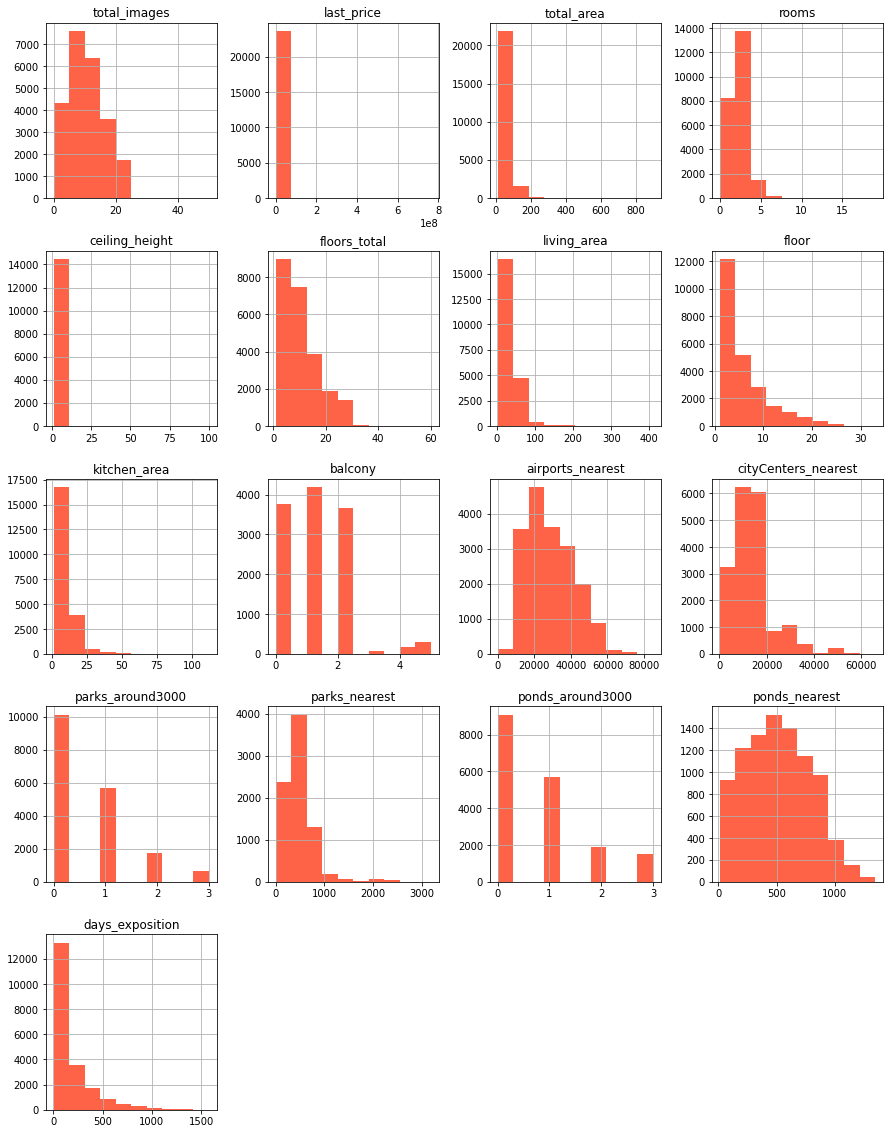

In [3]:
data.hist(figsize=(15, 20), color='tomato');

## Предобработка данных

Исследуем датасет на наличие пропусков

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски в данных могли образоваться по различным причинам: так, например, пропуски в $balcony$ могут объясняться тем, что в квартирах отсутсвует балкон, поэтому количество балконов не было указано, так же не всегда удобно указывать близжайшие парки и водоемы, так как это не является обязательным критерием выбора квартиры и так далее. Видим, что пропусков во почти во всех количественных признаках (в 13 из 17) есть пропуски, причем количество пропусков в каждом признаке от ~ 1% до 88%. Если просто выкинуть данные со всеми пропусками, то данных останется очень мало, а значит надо их как-то заполнить. Пропуски в балконах логичнее заполнить нулями, так как отсутствие информации о балконах вероятнее свидетельствует об его остсутсвии. Выcоту потолков мjжно заполнить следующим образом: найти квартиру в этом же ЖК/доме и взять это значение (так как высота потолков будет везде одинаковая) или же посмотреть на дома рядом и заполнить этими же значениями. Пропуски в данных о наличии парка/водоема/аэропорта можно заполнить точно так же: найти квартиры по этому же адресу или ближайшему у нему и заполнить этими значениями пропуски. Однако у нас нет адреса каждой квартиры и мы не можем разбить на группы квартир по населенному пункту. Поэтому можно предположить, что квартиры с одинаковой отдаленностью от центра будут похожи, поэтому можно сгруппировать данные по населенным пунктам и отдаленностью квартиры от центра, и заполнить пропуски парков/водоемов медианным значением, а расстояние до аэропорта средним значением. Еще видим, что пропусков в населенных пунктах $locality$ $name$ мало, всего 49, поэтому эти данные можем отбросить. Так же можем отбросить $floors$ $total$, так как распределение никак не изменится.

In [5]:
before = pd.DataFrame()
before['floors_total'] = data['floors_total']

In [6]:
data['balcony'] = data['balcony'].fillna(value=0)
data = data.dropna(subset=['locality_name'])
data = data.dropna(subset=['floors_total'])
# data.isna().sum()

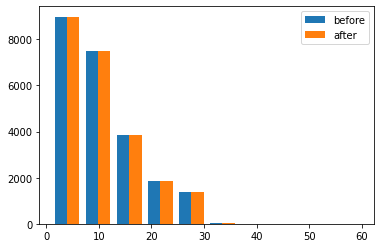

In [7]:
# data.plot(y='floors_total', kind='hist', color='pink')
# before.plot(y='floors_total', kind='hist', color='pink')
plt.hist([before['floors_total'], data['floors_total']], label=['before', 'after'])
plt.legend()
plt.show()

Посмотрим количество прудов и парков в каждом населенном пункте.

In [8]:
data.pivot_table(index='locality_name', values=['parks_around3000', 'ponds_around3000'], aggfunc = ['mean', 'median'])

mean                            median  \
                        parks_around3000 ponds_around3000 parks_around3000   
locality_name                                                                
Зеленогорск                     1.916667         0.875000              3.0   
Колпино                         0.522255         0.997033              0.0   
Красное Село                    0.482759         0.091954              0.0   
Кронштадт                       1.789474         1.936842              2.0   
Ломоносов                       0.242424         1.128788              0.0   
Павловск                        1.552632         1.842105              2.0   
Петергоф                        1.338308         1.308458              1.0   
Пушкин                          0.747967         0.872629              1.0   
Санкт-Петербург                 0.627606         0.770188              0.0   
Сестрорецк                      0.601093         1.207650              0.0   
поселок Лисий Нос               0.000000         0.000000              0.0   
посёлок Александровская         0.000000         1.000000              0.0   
посёлок Белоостров              0.000000         1.000000              0.0   
посёлок Левашово                0.000000         0.000000              0.0   
посёлок Лисий Нос               0.000000         0.000000              0.0   
посёлок Металлострой            0.000000         0.000000              0.0   
посёлок Молодёжное              0.000000         0.000000              0.0   
посёлок Парголово               0.030581         0.290520              0.0   
посёлок Песочный                0.000000         0.000000              0.0   
посёлок Петро-Славянка          0.000000         2.000000              0.0   
посёлок Понтонный               0.000000         0.350000              0.0   
посёлок Репино                  0.000000         0.000000              0.0   
посёлок Сапёрный                0.000000         1.000000              0.0   
посёлок Стрельна                0.720930         1.069767              0.0   
посёлок Усть-Ижора              0.000000         0.000000              0.0   
посёлок Шушары                  0.000000         0.348624              0.0   

                                          
                        ponds_around3000  
locality_name                             
Зеленогорск                          1.0  
Колпино                              1.0  
Красное Село                         0.0  
Кронштадт                            2.0  
Ломоносов                            1.0  
Павловск                             2.0  
Петергоф                             1.0  
Пушкин                               0.0  
Санкт-Петербург                      1.0  
Сестрорецк                           1.0  
поселок Лисий Нос                    0.0  
посёлок Александровская              1.0  
посёлок Белоостров                   1.0  
посёлок Левашово                     0.0  
посёлок Лисий Нос                    0.0  
посёлок Металлострой                 0.0  
посёлок Молодёжное                   0.0  
посёлок Парголово                    0.0  
посёлок Песочный                     0.0  
посёлок Петро-Славянка               2.0  
посёлок Понтонный                    0.0  
посёлок Репино                       0.0  
посёлок Сапёрный                     1.0  
посёлок Стрельна                     1.0  
посёлок Усть-Ижора                   0.0  
посёлок Шушары                       0.0

In [9]:
data.groupby('locality_name')['locality_name'].count().count()

364

По данной таблице можно понять, что далеко не у всех населенных пунктах указаны количества парков и прудов, поэтому сделать так, как предполагалось. Поэтому просто поставим "заглушки" на эти данные.

In [10]:
data['parks_around3000'] = data['parks_around3000'].fillna(-1)
data['ponds_around3000'] = data['ponds_around3000'].fillna(-1)

Теперь заполним пропуски в столбцах $parks$ $nearest$ и $ponds$ $nearest$. Посмотрим на распределения этих признаков и сравним с распределением после заполнения медианным значением по населенным пунктам. В этой ситуации сделать, по-моему мнению, так сделать не совсем корректно, так как расстояния от квартиры до парка не есть медианное значение, так как погрешность здесь будет равна примерно самому медианному (или среднему) значению.

In [11]:
before['parks_nearest'] = data['parks_nearest']
before['ponds_nearest'] = data['ponds_nearest']

In [12]:
parks_nearest_new = []
ponds_nearest_new = []

parks_nearest_new = data['parks_nearest'].fillna(
    data.groupby('locality_name')['parks_nearest'].transform('median')
)
ponds_nearest_new = data['ponds_nearest'].fillna(
    data.groupby('locality_name')['ponds_nearest'].transform('median')
)

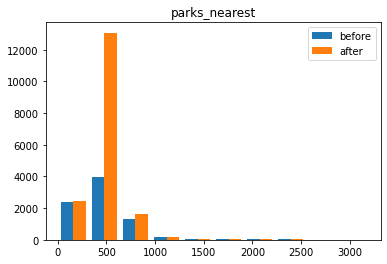

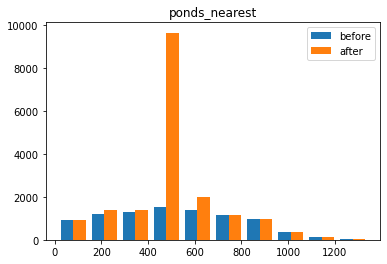

In [13]:
plt.hist([before['parks_nearest'], parks_nearest_new], label=['before', 'after'])
plt.legend()
plt.title('parks_nearest')
plt.show()

plt.hist([before['ponds_nearest'], ponds_nearest_new], label=['before', 'after'])
plt.legend()
plt.title('ponds_nearest')
plt.show()

Как и ожидалось, распределение сильно изменилось в сторону медианного значения. То есть ~ 63% в данных это пропуски, но так как распределение меняется, то лучше будет поставить заглушки вместо пропусков, чтобы данные по другим признакам остались

In [14]:
data['parks_nearest'] = data['parks_nearest'].fillna(-1)
data['ponds_nearest'] = data['ponds_nearest'].fillna(-1)

Далее заполним пропуски для столбца $is$ $apartment$.

In [15]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Можно выдвинуть гипотезу о том, что челевек ничего не указал в случае, когда это не апартаменты. Поэтому заполним пропуски значениями $False$.

In [16]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Далее приступим к заполению пропусков $kitchen$ $aria$. Можно предположить, что кухни во всех домах будут примерно одинаковыми. Поэтому посмотрим на площадь кухонь в населенных пунктах и заполним пропуски медианным значением. Однако пропусков ~ 10%, да и задача стоит в изучении зависимости, поэтому лучше оставим наны.

In [17]:
data['kitchen_area'] = data['kitchen_area'].fillna(-1)

Посмотрим на высоту потолков.

In [18]:
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

In [19]:
data['ceiling_height'].isna().sum()

9084

Видим, что в данных есть выбросы, и наны. Нанов много, ~ 40%, если их выкинуть, то данных останется мало. Посмотрим на распределение высоты потолков. 

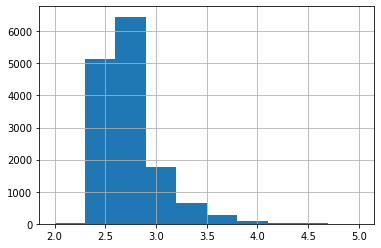

In [20]:
before['ceiling_height'] = data['ceiling_height']
data['ceiling_height'].hist(range=(2, 5));

В данном случае пропуски можно заполнить медианным значением по населенному пункту, так как в среднем высота потолков примерно одинаковая. Однако с другой стороны высота потолков может влиять на продажу квартиры (например покупатели в поиске квартиры с высокими потолками). Посмотрим как изменится распределение после заполнения пропусками медианными значениями.

In [21]:
data['ceiling_height'] = data['ceiling_height'].fillna(
    data.groupby('locality_name')['ceiling_height'].transform('median')
)
data['ceiling_height'].isna().sum()

120

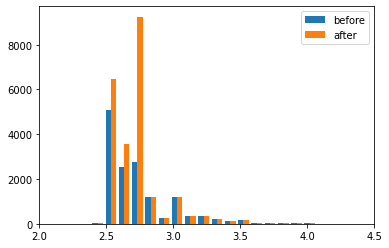

In [22]:
plt.hist([before['ceiling_height'], data['ceiling_height']], label=['before', 'after'], bins=1000)
plt.legend()
plt.xlim(2, 4.5)
plt.show()

Оставшиеся пропуски обусловлены отсутсвием данных о высоте потолка в некоторых населеных пунктах. Пропусков осталось 120, можем их просто выкинуть.

Заметим, что распределение почти не изменилось, как и ожидалось, подскочили пики с медианными значениями. Однако все же оставим даннами именно такими, так как иначе данных останется мало.

In [23]:
data = data.dropna(subset=['ceiling_height'])
data['ceiling_height'].isna().sum()

0

Заполним пропуски расстояния до центра города и до аэропорта так же медианным значением по населенным пунктам. Это логичное заполение пропусков, так как квартиры, находящиеся в одном городе будут иметь близкое значение расстояний до центра (то есть до Санкт-Петербурга) и до аэропорта. Значения будут иметь погрешность радиуса населенного пункта, поэтому распределение не изменится.

In [24]:
before['cityCenters_nearest'] = data['cityCenters_nearest']
before['airports_nearest'] = data['airports_nearest']

In [25]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(
    data.groupby('locality_name')['cityCenters_nearest'].transform('median')
)
data['airports_nearest'] = data['airports_nearest'].fillna(
    data.groupby('locality_name')['airports_nearest'].transform('median')
)

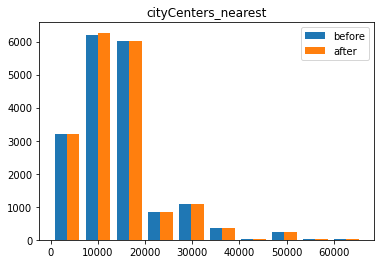

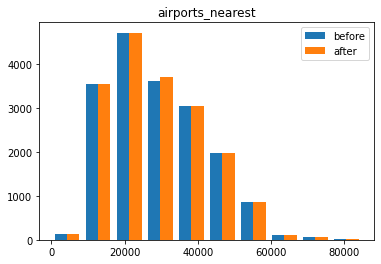

In [26]:
plt.hist([before['cityCenters_nearest'], data['cityCenters_nearest']], label=['before', 'after'])
plt.legend()
plt.title('cityCenters_nearest')
plt.show()

plt.hist([before['airports_nearest'], data['airports_nearest']], label=['before', 'after'])
plt.legend()
plt.title('airports_nearest')
plt.show()

Ожидаемо распределение не изменилось, поэтому именно так и заполним пропуски. Посмотрим, все ли пропуски оказались заполнены.

In [27]:
print('Количество пропусков:', data['cityCenters_nearest'].isna().sum(), data['airports_nearest'].isna().sum())

Количество пропусков: 5317 5317


Что это может означать? По моему предположению, как и в некоторых пунктах выше, это может означать отсутсвие данной информации для конкретных населенных пунктов. Такие данные можно заполнить, если знать больше данных, например георграфического расположения, то можно было бы заполнить медианным значением расстояния от населенных пунктов в окрестности. Однако такой иформации нет, поэтому чтобы не засорять данными произвольными значениями, можем либо поставить заглушки на пропуски (чтобы сохранить данные по другим столбцам), либо удалить. Выберем первый вариант, чтобы сохранить побольше данных о других признаках.

In [28]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(-1)
data['airports_nearest'] = data['airports_nearest'].fillna(-1)

Рассмотрим теперь столбец $days$ $exposition$. У нас есть дата публикации, однако не понятно до какого дня считается. Можно было бы посмотреть сколько дней прошло со дня публикации у известных публикаций квартир, однако не факт, что у всех квартир показан один период, поэтому чтобы не засорять данные, просто выкинем из рассмотрения или поставим заглушку. Пропусков ~ 10%, поэтому лучше поставим заглушку как и выше, для того, чтобы в других признаках осталось больше данных.

In [29]:
data['days_exposition'] = data['days_exposition'].fillna(-1)

Осталось разобраться только с пропусками $living$ $area$. Жилая площать - это площадь только комнат (то есть исключая площадь квартир, санузла, ванной и коридора). Из всего у нас имется только площадь кухни. Поэтому пересчитать пропуски не представляется возможным. Можно заполнить данные медианным значением по категориям квартир с похожеми площадами всей квартиры и площадью кухни. Но так как пропусков всего порядка ~ 8%, что не кретически много, то можно просто выкинуть эти данные из рассмотрения.

In [30]:
data = data.dropna(subset=['living_area'])

Убедимся в том, что пропусков больше не осталось.

In [31]:
data.isna().sum()

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64

Теперь приступим к рассмотрению типов данных.

Изменим необходимые типы данных: $balcony$, $days$ $exposition$, $first$ $day$ $exposition$, $parks$ $nearest$, $ponds$ $nearest$, $floors$ $total$.

In [32]:
data['balcony'] = data['balcony'].astype('int')
data['parks_nearest'] = data['parks_nearest'].astype('int')
data['ponds_nearest'] = data['ponds_nearest'].astype('int')
data['days_exposition'] = data['days_exposition'].astype('int')
data['floors_total'] = data['floors_total'].astype('int')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21604 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21604 non-null  int64         
 1   last_price            21604 non-null  float64       
 2   total_area            21604 non-null  float64       
 3   first_day_exposition  21604 non-null  datetime64[ns]
 4   rooms                 21604 non-null  int64         
 5   ceiling_height        21604 non-null  float64       
 6   floors_total          21604 non-null  int64         
 7   living_area           21604 non-null  float64       
 8   floor                 21604 non-null  int64         
 9   is_apartment          21604 non-null  bool          
 10  studio                21604 non-null  bool          
 11  open_plan             21604 non-null  bool          
 12  kitchen_area          21604 non-null  float64       
 13  balcony         

Тип данных нужно изменить для того, чтобы применять разные методы и в целом понимать, что некоторые данные могут быть только целыми (например, число балконов не может быть 1.5).

Теперь разберемся с аномальными значениями. Будем разбираться со всеми данными по порядку. А именно будем уыбирать аномальные значения в столбцах: $last$ $price$, $rooms$, $ceiling$ $height$, $floors$ $total$, $floor$, $balcony$, $parks$ $around3000$, $ponds$ $around3000$. Во всех остальных данных не представляется возможность понять является ли значения аномальным.

In [33]:
data['last_price'].describe()

count    2.160400e+04
mean     6.520969e+06
std      1.090405e+07
min      1.219000e+04
25%      3.480000e+06
50%      4.650000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

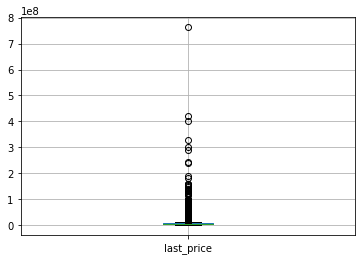

In [34]:
data.boxplot(column=['last_price']);

Обработаем выбросы, откинув значения цены квартры больше, чем 99 процентиль.

In [35]:
Q_99 = np.percentile(data['last_price'], 99)
data[data['last_price'] < Q_99].count().count()

22

Таких выбросов очень мало, всего 22.

In [36]:
data['last_price'] = data['last_price'].where(data['last_price'] < Q_99, -1)

count    2.160400e+04
mean     5.750659e+06
std      4.195259e+06
min     -1.000000e+00
25%      3.400000e+06
50%      4.600000e+06
75%      6.649250e+06
max      3.497900e+07
Name: last_price, dtype: float64

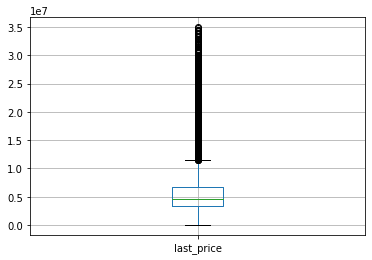

In [37]:
data.boxplot(column=['last_price']);
data['last_price'].describe()

Теперь мы убрали выбросы в столбце цены. Посмотрим как поменялось распределение.

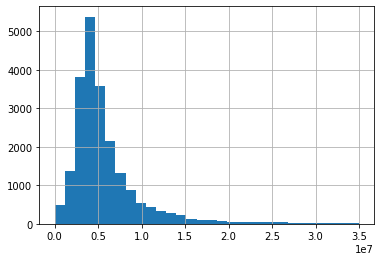

In [38]:
data['last_price'].hist(bins=30);

Распределение, как и ожидалось, не изменилось, поэтому данные мы преобразовали верно. Однако так как нам необходимо исследовать зависимость признаков, поэтому эти выбросы (чтобы не менять статистику), проще выкинуть из рассмотрения.

In [39]:
data = data[data['last_price'] != -1]

Теперь обработаем количество комнат.

In [40]:
data['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0, 11,  7,  8, 14, 10,  9, 19, 16])

Тяжело представить квартиру с числом комнат > 5. И не ясно, что такое квартира с числом комнат равному 0. Поэтому отсортируем такие квартиры и поставим им флаги неопределенности количества комнат.

In [41]:
data['rooms'] = data['rooms'].where((data['rooms'] <= 5) & (data['rooms'] != 0), -1 )
data['rooms'].value_counts()

 1    7325
 2    7204
 3    5252
 4    1027
-1     316
 5     253
Name: rooms, dtype: int64

In [42]:
data['ceiling_height'].unique()

array([  2.7  ,   2.615,   3.03 ,   2.6  ,   2.64 ,   2.5  ,   2.67 ,
         2.55 ,   2.56 ,   3.05 ,   2.75 ,   2.9  ,   2.8  ,   3.   ,
         2.65 ,   2.61 ,   3.2  ,   3.25 ,   3.45 ,   2.77 ,   2.85 ,
         2.525,   2.57 ,   4.15 ,   3.3  ,   2.71 ,   4.   ,   2.47 ,
         2.73 ,   2.84 ,   3.1  ,   3.4  ,   3.5  ,   2.52 ,   2.72 ,
         2.54 ,   2.51 ,   2.78 ,  13.85 ,   2.76 ,  25.   ,   2.58 ,
         3.7  ,   2.87 ,   2.66 ,   2.56 ,   2.59 ,   2.   ,   2.45 ,
         3.6  ,   3.9  ,   2.92 ,   3.11 ,   3.13 ,   3.8  ,   3.15 ,
         3.55 ,   3.16 ,   3.62 ,   3.12 ,   2.53 ,   2.96 ,   2.46 ,
         2.74 ,   2.95 ,   4.06 ,   2.94 ,   2.79 ,   3.54 ,   3.53 ,
         2.83 ,   2.4  ,   3.38 ,   3.01 ,   3.65 ,   3.18 ,   3.35 ,
         2.3  ,   3.57 ,   2.48 ,   2.515,   2.62 ,   2.82 ,   2.65 ,
         3.98 ,   2.63 ,   3.83 ,  27.   ,   3.52 ,   3.95 ,   3.75 ,
         2.88 ,   3.67 ,   3.87 ,   3.66 ,   3.86 ,   4.19 ,   3.24 ,
         4.8  ,   4.

Понятно, что не бывает потолков высотой больше 10 метров (10 метров крайний случай, когда в квартире несколько этажей и это "второй свет"). Так что все значения, которые между 25 и 40 будем нормировать на 10. То есть выдвенем гипотезу о том, что такие значения ввели некорректно, например, забыли поставить разделитель. Значения от 0 до 2.5, от 4 до 25, и > 40 будем помечать флагом ошибки (отсутсвия корректных данных). Напишем функцию, которая будет заменять наши значения.

In [43]:
def ceiling_height_normal(height):
    if (height >= 25) and (height <= 40):
        return height/10
    if (height > 0) and (height < 2.5):
        return -1
    if (height > 4) and (height < 25):
        return -1
    if height > 40:
        return -1
    if (height >= 2.5) and (height <= 4):
        return height

In [44]:
data['ceiling_height'] = data['ceiling_height'].apply(ceiling_height_normal)

In [45]:
data['ceiling_height'].unique()

array([ 2.7  ,  2.615,  3.03 ,  2.6  ,  2.64 ,  2.5  ,  2.67 ,  2.55 ,
        2.56 ,  3.05 ,  2.75 ,  2.9  ,  2.8  ,  3.   ,  2.65 ,  2.61 ,
        3.2  ,  3.25 ,  3.45 ,  2.77 ,  2.85 ,  2.525,  2.57 , -1.   ,
        3.3  ,  2.71 ,  4.   ,  2.73 ,  2.84 ,  3.1  ,  3.4  ,  3.5  ,
        2.52 ,  2.72 ,  2.54 ,  2.51 ,  2.78 ,  2.76 ,  2.58 ,  3.7  ,
        2.87 ,  2.66 ,  2.56 ,  2.59 ,  3.6  ,  3.9  ,  2.92 ,  3.11 ,
        3.13 ,  3.8  ,  3.15 ,  3.55 ,  3.16 ,  3.62 ,  3.12 ,  2.53 ,
        2.96 ,  2.74 ,  2.95 ,  2.94 ,  2.79 ,  3.54 ,  3.53 ,  2.83 ,
        3.38 ,  3.01 ,  3.65 ,  3.18 ,  3.35 ,  3.57 ,  2.515,  2.62 ,
        2.82 ,  2.65 ,  3.98 ,  2.63 ,  3.83 ,  3.52 ,  3.95 ,  3.75 ,
        2.88 ,  3.67 ,  3.87 ,  3.66 ,  3.86 ,  3.24 ,  3.36 ,  3.68 ,
        3.07 ,  3.37 ,  3.09 ,  3.26 ,  3.34 ,  2.81 ,  3.44 ,  2.97 ,
        3.14 ,  2.725,  2.68 ,  2.6  ,  3.22 ,  3.27 ,  2.675,  2.93 ,
        3.46 ,  3.47 ,  3.63 ,  2.625,  3.33 ,  3.32 ,  2.98 ,  2.86 ,
      

Теперь изучим столбец $floors$ $total$. 

In [46]:
data['floors_total'].unique()

array([16, 11,  5, 14, 12, 26, 27,  9,  6, 17, 25,  3, 23, 19, 18,  4, 24,
        2, 10,  7, 15,  8, 22, 13, 20, 28, 36, 21, 35, 34, 60,  1, 29, 33,
       52, 37])

Будем считать, что этажей в доме не может быть меньше 2 и не может быть больше 50. Поэтому дальше снова все значения, которые не удовлетворяют нашим требованиям будем помечасть флагом.

In [47]:
def floors_total_normal(floors_total):
    if floors_total < 2:
        return -1
    if floors_total > 50:
        return -1
    else:
        return floors_total

In [48]:
data['floors_total'] = data['floors_total'].apply(floors_total_normal)

In [49]:
data['floors_total'].unique()

array([16, 11,  5, 14, 12, 26, 27,  9,  6, 17, 25,  3, 23, 19, 18,  4, 24,
        2, 10,  7, 15,  8, 22, 13, 20, 28, 36, 21, 35, 34, -1, 29, 33, 37])

Аналогично делаем со столбцом $floor$. Будем предполагать, что максимальное количество этажей 50. Все, что больше, отмечаем флагом.

In [50]:
data['floor'].unique()

array([ 8,  1,  4, 13,  5,  6, 26,  7,  3,  2, 11, 15,  9, 18, 22, 10, 19,
       20, 27, 25, 17, 14, 12, 21, 28, 24, 16, 23, 30, 29, 32, 33, 31])

Заметим, что данные исправлять никак не надо, так как значения в пределах 33.

Посмотрим теперь на количество балконов, парков и прудов.

In [51]:
data['balcony'].unique()

array([0, 2, 1, 5, 4, 3])

In [52]:
data['parks_around3000'].unique()

array([ 1.,  0.,  2., -1.,  3.])

In [53]:
data['ponds_around3000'].unique()

array([ 2.,  0.,  1., -1.,  3.])

В этих данных никаких аномальных значений не выявлено. Поэтому перейдем в следующему этапу: обработка дубликатов. Проверим данные на явные дубликаты.

In [54]:
data.duplicated().sum()

0

Явных дуликатов не выявлено, поэтому приступим к поиску неявных дубликатов. Такие могут иметься только в столбце с населенными пунктами $locality$ $name$.

In [55]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Колпино', 'Гатчина',
       'поселок Мурино', 'деревня Фёдоровское', 'Выборг', 'Кронштадт',
       'Кировск', 'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск', 'Всеволожск',
       'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'деревня Куттузи', 'посёлок Аннино', 'поселок Торковичи',
       'поселок Первомайское', 'Красное Село', 'посёлок Понтонный',
       'деревня Старая', 'деревня Лесколово', 'село Путилово',
       'Ивангород', 'Мурино', 'Сланцы', 'Шлиссельбург', 'Сясьстрой',
       'Никольское', 'Зеленогорск', 'Сосновый Бор', 'поселок Новый Свет',
       'деревня Оржицы', 

In [56]:
data['locality_name'] = data['locality_name'].replace('ё', 'е')
data['normalized_locality_name'] = data['locality_name'].str.lower()
data.duplicated().sum()

0

Теперь сделаем замену

In [57]:
data['locality_name'] = data['locality_name'].astype('str')

In [58]:
for locality_name in data['locality_name'].unique():
    select = data['locality_name'].str.contains(locality_name)
    data.loc[select, 'locality_name'] = locality_name

### 3. Добавление в таблицу новых столбцов со следующими параметрами

1. цена одного квадратного метра;
2. день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
3. месяц публикации объявления;
4. год публикации объявления;
5. тип этажа квартиры (значения — «первый», «последний», «другой»);
6. расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [59]:
# функция, выдающая тип этажа квартиры
def type_floor_apart(data):
    if data['floor'] == 1:
        return 'первый'
    if data['floor'] == data['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [60]:
data['price_sq_met'] = data['last_price']/data['total_area']
data['day_public'] = data['first_day_exposition'].dt.weekday
data['month_public'] = data['first_day_exposition'].dt.month
data['year_public'] = data['first_day_exposition'].dt.year
data['type_floor_apart'] = data.apply(type_floor_apart, axis = 1)
data['dist_center_km'] = round(data['cityCenters_nearest']/1000).astype('int')

In [61]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,normalized_locality_name,price_sq_met,day_public,month_public,year_public,type_floor_apart,dist_center_km
0,20,13000000.0,108.0,2019-03-07,3,2.700,16,51.0,8,False,...,2.0,755,-1,санкт-петербург,120370.370370,3,3,2019,другой,16
1,7,3350000.0,40.4,2018-12-04,1,2.615,11,18.6,1,False,...,0.0,-1,81,посёлок шушары,82920.792079,1,12,2018,первый,19
2,10,5196000.0,56.0,2015-08-20,2,2.700,5,34.3,4,False,...,2.0,574,558,санкт-петербург,92785.714286,3,8,2015,другой,14
4,2,10000000.0,100.0,2018-06-19,2,3.030,14,32.0,13,False,...,1.0,48,121,санкт-петербург,100000.000000,1,6,2018,другой,8
5,10,2890000.0,30.4,2018-09-10,1,2.600,12,14.4,5,False,...,-1.0,-1,55,городской посёлок янино-1,95065.789474,0,9,2018,другой,0


### 4. Исследовательский анализ данных
Изучим следующие параметры объектов:
1. общая площадь;
2. жилая площадь;
3. площадь кухни;
4. цена объекта;
5. количество комнат;
6. высота потолков;
7. этаж квартиры;
8. тип этажа квартиры («первый», «последний», «другой»);
9. общее количество этажей в доме;
10. расстояние до центра города в метрах;
11. расстояние до ближайшего аэропорта;
12. расстояние до ближайшего парка;
13. день и месяц публикации объявления.

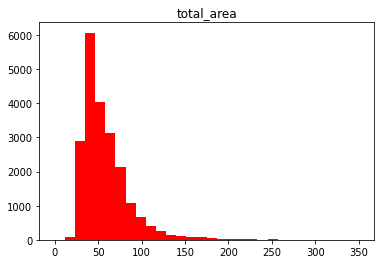

In [62]:
plt.hist(data['total_area'], bins=30, range=(0, 350), color='red')
plt.title('total_area')
plt.show()

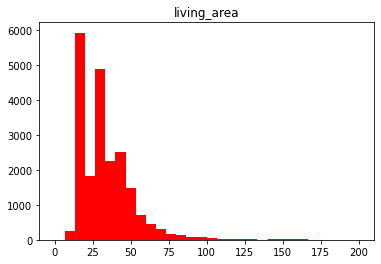

In [63]:
plt.hist(data['living_area'], bins=30, range=(0, 200), color='red');
plt.title('living_area')
plt.show()

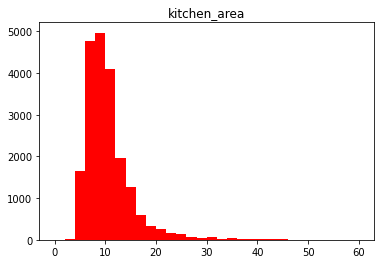

In [64]:
plt.hist(data['kitchen_area'], bins=30, range=(0, 60), color='red');
plt.title('kitchen_area')
plt.show()

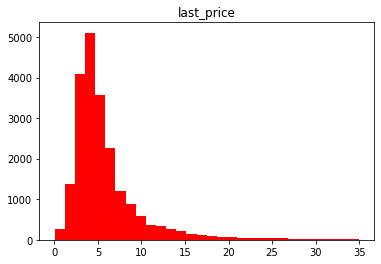

In [65]:
plt.hist(data['last_price']/10**6, bins=30, color='red');
plt.title('last_price')
plt.show()

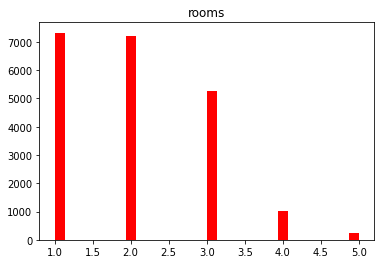

In [66]:
plt.hist(data['rooms'], bins=30, range=(1, 5), color='red');
plt.title('rooms')
plt.show()

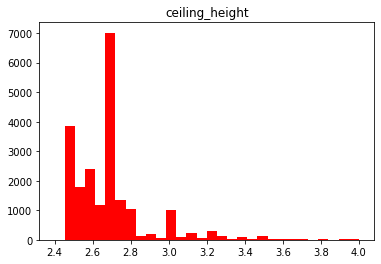

In [67]:
plt.hist(data['ceiling_height'], bins=30, range=(2.4, 4), color='red');
plt.title('ceiling_height')
plt.show()

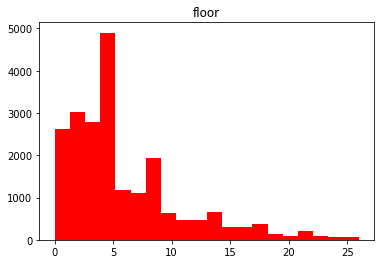

In [68]:
plt.hist(data['floor'], bins=20, range=(0, 26), color='red');
plt.title('floor')
plt.show()

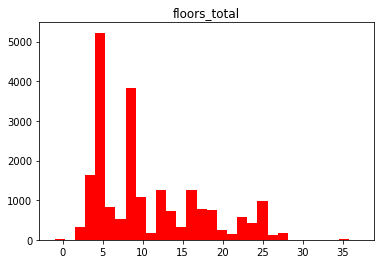

In [69]:
plt.hist(data['floors_total'], bins=30, color='red');
plt.title('floors_total')
plt.show()

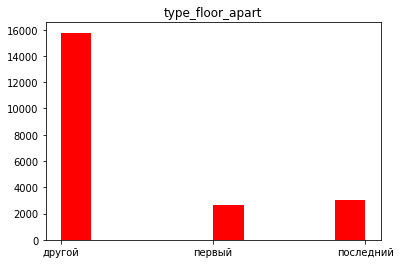

In [70]:
plt.hist(data['type_floor_apart'], color='red')
plt.title('type_floor_apart')
plt.show()

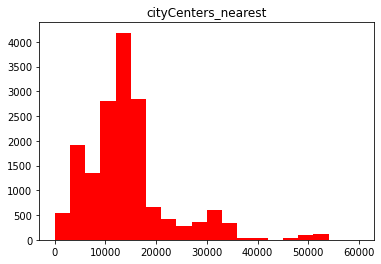

In [71]:
plt.hist(data['cityCenters_nearest'], bins=20, range=(0, 60000), color='red');
plt.title('cityCenters_nearest')
plt.show()

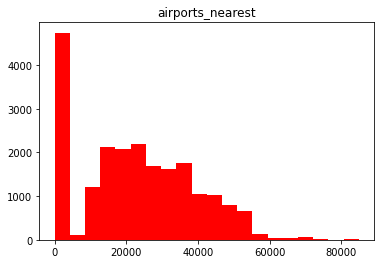

In [72]:
plt.hist(data['airports_nearest'], bins=20, color='red');
plt.title('airports_nearest')
plt.show()

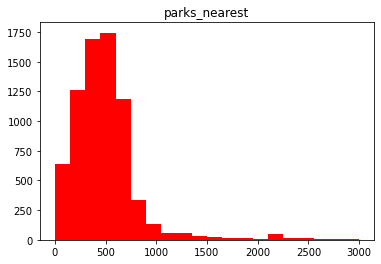

In [73]:
plt.hist(data['parks_nearest'], range=(0, 3000), bins=20, color='red');
plt.title('parks_nearest')
plt.show()

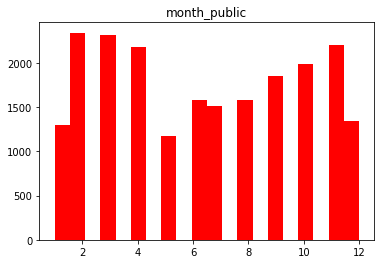

In [74]:
plt.hist(data['month_public'], bins=20, color='red');
plt.title('month_public')
plt.show()

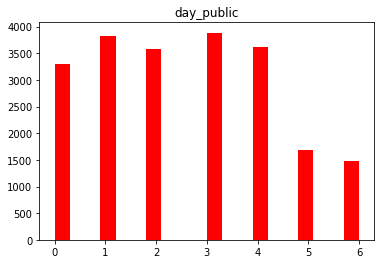

In [75]:
plt.hist(data['day_public'], bins=20, color='red');
plt.title('day_public')
plt.show()

Распределения всех величин, за исключением дня и месяца публикации объявления, количества комнат, высота потолков, этаж квартиры, близки к нормальному. Распределение этажа квартиры и высоты потолков близки к распределению Пуассона. Все это отражает реальность данных. Данные уже обработаны, никаких выбросов не наблюдаем. Флаги, которые мы ставили во время обработки, в некоторых гистограммах были обрезаны для того, чтобы отразить только распределение нужных данных.

Изучим теперь как быстро продавались квартиры. Для этого построим гистограмму, посчитаем среднее и медиану.

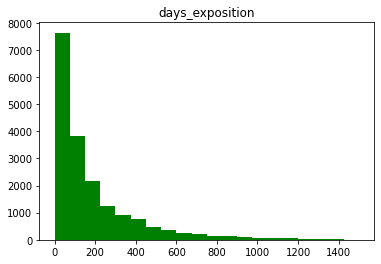

In [76]:
plt.hist(data['days_exposition'], bins=20, range=(0, 1500), color='green')
plt.title('days_exposition')
plt.show()

In [77]:
print('Среднее значение количества дней на продаже:', data['days_exposition'].mean())
print('Медианное значение количества дней на продаже:', data['days_exposition'].median())

Среднее значение количества дней на продаже: 158.802825466623
Медианное значение количества дней на продаже: 77.0


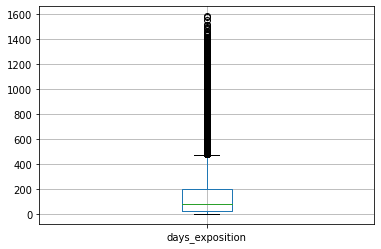

In [78]:
data.boxplot(column=['days_exposition']);

In [79]:
data['days_exposition'].describe()

count    21377.000000
mean       158.802825
std        214.786225
min         -1.000000
25%         22.000000
50%         77.000000
75%        203.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее количество дней для продажи квартиры: 160, медианное значение: 78 дней. Аномально быстрыми будем считать продажи за 21 день или меньше (первый квартиль). Аномально долгими продажами будем считать 205 дней и выше (третий квартиль). 

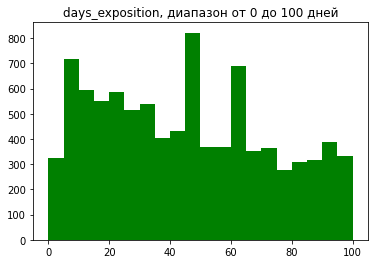

In [80]:
plt.hist(data['days_exposition'], bins=20, range=(0, 100), color='green')
plt.title('days_exposition, диапазон от 0 до 100 дней')
plt.show()

In [81]:
data[(data['days_exposition'] <= 100) & (data['days_exposition'] > 0)]['days_exposition'].describe()

count    9256.000000
mean       44.538137
std        27.529890
min         1.000000
25%        20.000000
50%        44.000000
75%        65.000000
max       100.000000
Name: days_exposition, dtype: float64

Если рассмотреть диапазон от 0 до 100 дней продажи, что можно на диаграмме увидеть, что пиковые значения приходятся на ~ 10, 50, 60 дни. Это особенность функционирования системы размещений объявлений.

Теперь построим матрицу корреляции признаков друг с другом для того, чтобы проанализировать зависимости признаков друг от друга. А именно изучим, зависит ли цена от:
1. общей площади;
2. жилой площади;
3. площади кухни;
4. количества комнат;
5. этажа, на котором расположена квартира (первый, последний, другой);
6. даты размещения (день недели, месяц, год).

Посмотрим на матрицу корреляции и построим диаграмму корреляции.

In [82]:
data.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_met,day_public,month_public,year_public,dist_center_km
total_images,1.000000,0.155056,0.109392,0.098952,0.031152,0.010970,0.091586,0.032702,0.010396,-0.031157,...,0.039638,0.022856,0.017141,0.007007,-0.070627,0.138451,-0.007882,0.004835,0.158252,-0.000559
last_price,0.155056,1.000000,0.795592,0.397994,0.283437,0.055972,0.698006,0.065796,0.024896,-0.052394,...,0.370452,0.225368,0.361452,0.165728,0.070553,0.651696,-0.016195,-0.003747,-0.037759,-0.032080
total_area,0.109392,0.795592,1.000000,0.585664,0.241376,-0.067378,0.933618,-0.029879,0.007607,-0.085751,...,0.206224,0.125247,0.204794,0.091084,0.098991,0.136112,-0.012822,-0.001728,-0.079498,-0.068957
rooms,0.098952,0.397994,0.585664,1.000000,0.085095,-0.207643,0.636017,-0.146711,-0.006191,-0.226855,...,0.117754,0.064248,0.098254,0.045832,0.067318,-0.066171,-0.003751,-0.002559,-0.049281,-0.024261
ceiling_height,0.031152,0.283437,0.241376,0.085095,1.000000,0.008011,0.211652,0.006345,-0.002760,0.005750,...,0.162621,0.078342,0.149910,0.061618,0.042151,0.200599,-0.008000,-0.007628,-0.036046,-0.072322
floors_total,0.010970,0.055972,-0.067378,-0.207643,0.008011,1.000000,-0.172738,0.678134,-0.021595,0.073878,...,-0.069337,-0.064006,0.005966,0.013303,-0.028197,0.246341,0.009881,0.016778,0.008009,0.080047
living_area,0.091586,0.698006,0.933618,0.636017,0.211652,-0.172738,1.000000,-0.108654,0.007335,-0.062024,...,0.203162,0.108708,0.181125,0.082121,0.090563,0.051087,-0.009370,-0.007232,-0.068881,-0.074199
floor,0.032702,0.065796,-0.029879,-0.146711,0.006345,0.678134,-0.108654,1.000000,-0.010065,0.038812,...,-0.046759,-0.040507,0.003957,0.010199,-0.023431,0.192075,0.007664,0.018089,0.008657,0.051944
is_apartment,0.010396,0.024896,0.007607,-0.006191,-0.002760,-0.021595,0.007335,-0.010065,1.000000,-0.003414,...,0.014807,-0.010122,0.018616,0.014586,0.001967,0.045133,-0.009218,-0.005445,0.016484,0.010362
studio,-0.031157,-0.052394,-0.085751,-0.226855,0.005750,0.073878,-0.062024,0.038812,-0.003414,1.000000,...,-0.037752,-0.024334,-0.020683,-0.005402,-0.017225,0.030126,-0.000662,0.000420,0.010917,-0.024687


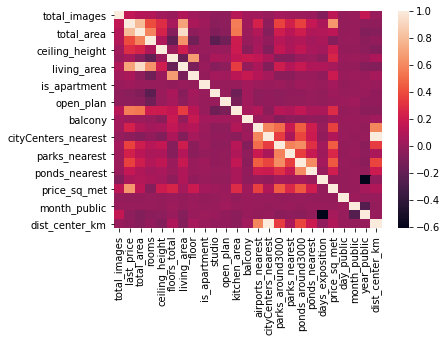

In [83]:
sns.heatmap(data.corr());

Теперь построим матрицу диаграмм рассеяния для иллюстрации зависимостей нужных признаков.

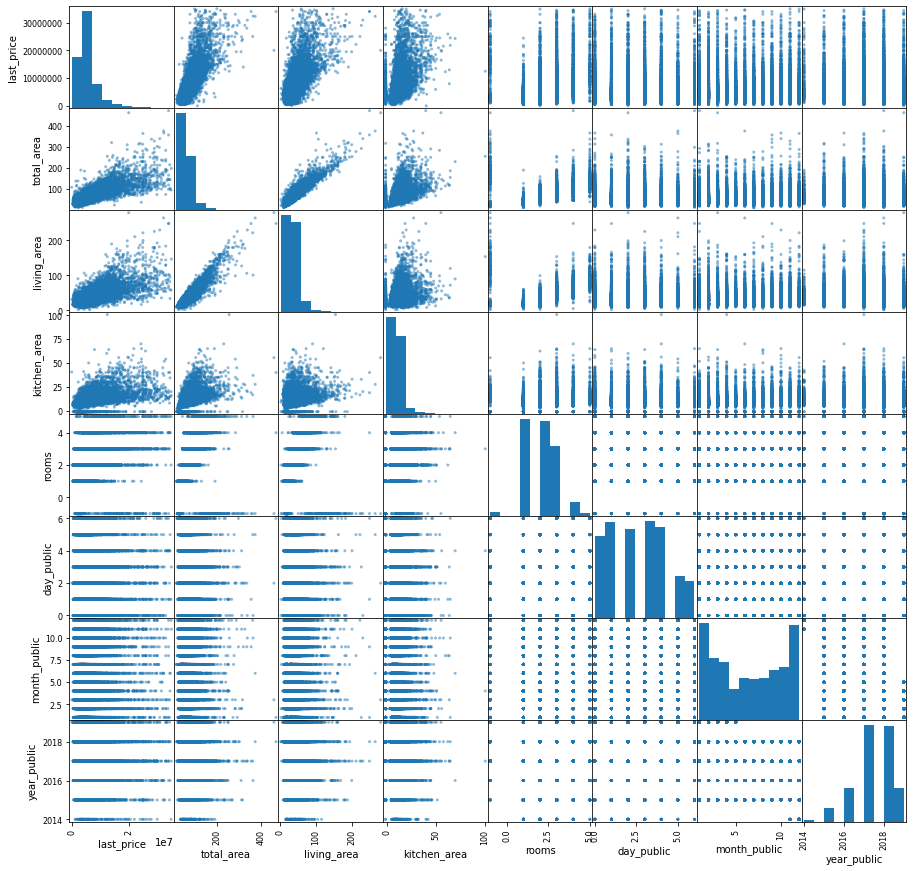

In [84]:
pd.plotting.scatter_matrix(
    data[['last_price', 'total_area', 'living_area', 'kitchen_area',\
         'rooms', 'type_floor_apart', 'day_public', 'month_public', 'year_public']],
    figsize=(15, 15)
);

Теперь построим диаграммы рассеяния для того, чтобы изучить зависимости нужных признаков от цены.

Коэффициент корреляции: 0.7955916272535731


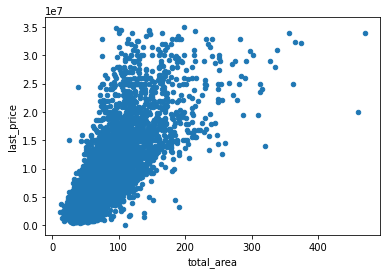

In [85]:
data.plot(x='total_area', y='last_price', kind='scatter');
print('Коэффициент корреляции:', data['total_area'].corr(data['last_price']))

Коэффициент корреляции: 0.6980055064805184


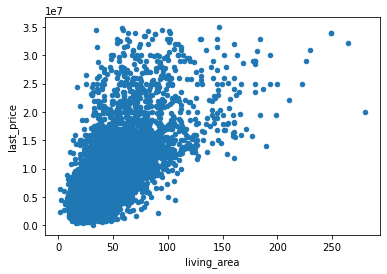

In [86]:
data.plot(x='living_area', y='last_price', kind='scatter');
print('Коэффициент корреляции:', data['living_area'].corr(data['last_price']))

Коэффициент корреляции: 0.5634754566960996


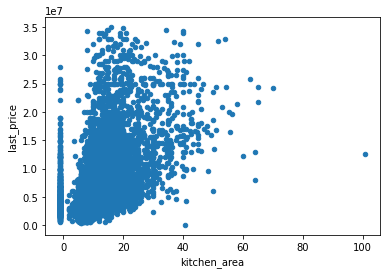

In [87]:
data.plot(x='kitchen_area', y='last_price', kind='scatter');
print('Коэффициент корреляции:', data['kitchen_area'].corr(data['last_price']))

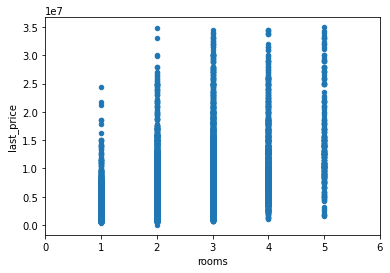

In [88]:
data.plot(x='rooms', y='last_price', kind='scatter');
plt.xlim(0, 6)
plt.show()

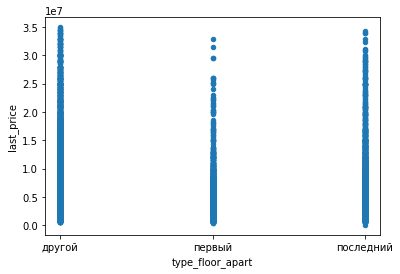

In [89]:
data.plot(x='type_floor_apart', y='last_price', kind='scatter');

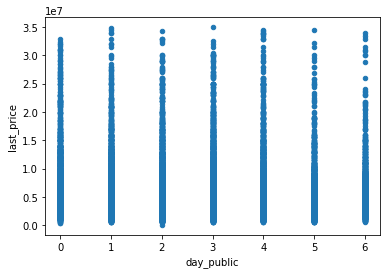

In [90]:
data.plot(x='day_public', y='last_price', kind='scatter');

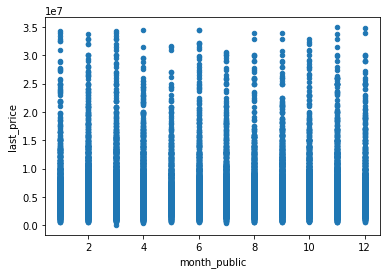

In [91]:
data.plot(x='month_public', y='last_price', kind='scatter');

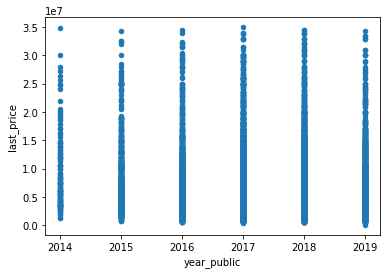

In [92]:
data.plot(x='year_public', y='last_price', kind='scatter');

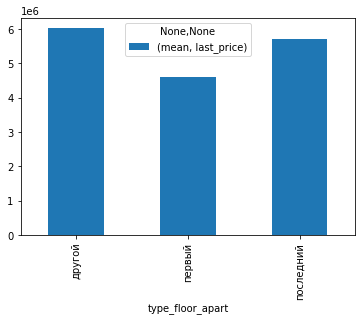

In [93]:
data_pivot_floor = data.pivot_table(index='type_floor_apart', values='last_price', aggfunc=['mean'])
data_pivot_floor.plot.bar()
plt.show()

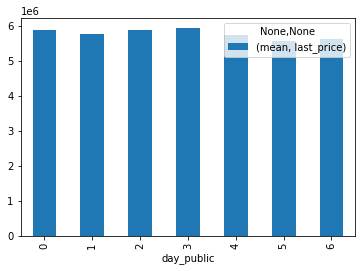

In [94]:
data_pivot_day = data.pivot_table(index='day_public', values='last_price', aggfunc=['mean'])
data_pivot_day.plot.bar()
plt.show()

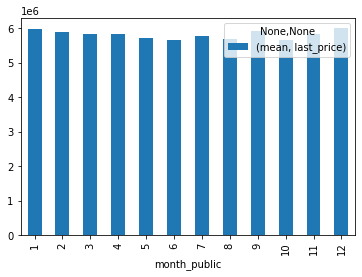

In [95]:
data_pivot_month = data.pivot_table(index='month_public', values='last_price', aggfunc=['mean'])
data_pivot_month.plot.bar()
plt.show()

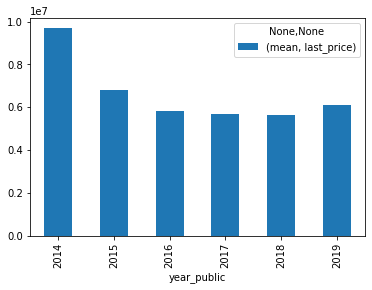

In [96]:
data_pivot_year = data.pivot_table(index='year_public', values='last_price', aggfunc=['mean'])
data_pivot_year.plot.bar()
plt.show()

По полученным диаграммам рассеяния и коэффициентам корреляции можем сделать следующий вывод: цена зависит от общей площади, жилой площади, площади кухни, количества комнат и типа этажа. Самая большая зависимость наблюдается у общей площади квартиры и цены. Это кажется очевидным: чем больше квартира, тем дороже она стоит. Зависимость цены от года, месяца и дня публикации отсутсвует или мала. От типа этажа зависимость тоже есть: из графика видно, что квартиры стоят дороже, если она располагается не на первом и не на последнем этаже. Из трех последних графиков можно заключить, что зависимость между днем/месяцем от цены отсутсвует, а зависимость между годом и ценой есть, наблюдается тенденция к снижению средней стоимости квартир.

Значит можно сделать вывод о том, что больше всего на стоимость квартиры влияет ее общая площадь. Но не только площадь может влиять на цену квартир, может влиять ее расположение от парков/прудов, удаленность от города/аэропорта, поэтому дополнительно изучим эти зависимости.

Коэффициент корреляции: -0.03207991463314488


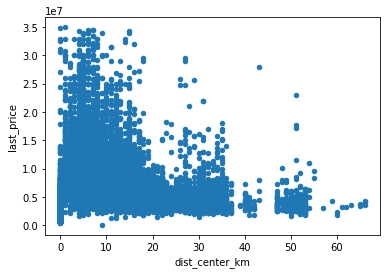

In [97]:
data.plot(x='dist_center_km', y='last_price', kind='scatter');
print('Коэффициент корреляции:', data['dist_center_km'].corr(data['last_price']))

Коэффициент корреляции: 0.2322723896395389


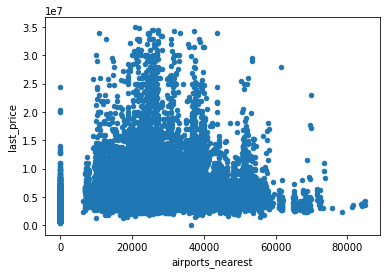

In [98]:
data.plot(x='airports_nearest', y='last_price', kind='scatter');
print('Коэффициент корреляции:', data['airports_nearest'].corr(data['last_price']))

Коэффициент корреляции: 0.22536758635815496


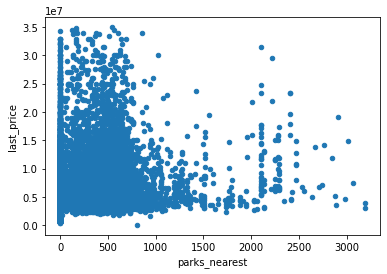

In [99]:
data.plot(x='parks_nearest', y='last_price', kind='scatter');
print('Коэффициент корреляции:', data['parks_nearest'].corr(data['last_price']))

Коэффициент корреляции: 0.16572796877171858


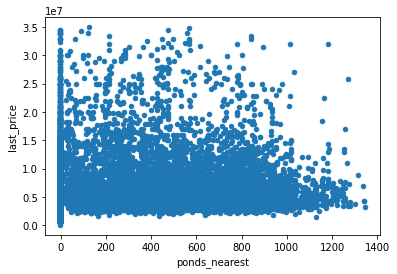

In [100]:
data.plot(x='ponds_nearest', y='last_price', kind='scatter');
print('Коэффициент корреляции:', data['ponds_nearest'].corr(data['last_price']))

Зависимости между этими параметрами есть, однако она небольшая. Получается, что самая большая зависимость между ценой и общей площадью квартиры. Но эта зависимость не единственная, почти все признаки влияют на ценообразование, но с малым коэффициентом.

Теперь посчитаем среднюю цену одного квадратного метра в 10 населенных пунктах с наибольшим числом объявлений.

In [101]:
data_pivot_sort = (data.pivot_table(index='locality_name', values=['price_sq_met'], aggfunc=['mean', 'median', 'count'])
    .sort_values(('count', 'price_sq_met'), ascending=False)
)
data_pivot_sort_top_10 = data_pivot_sort.head(10)
data_pivot_sort_top_10

,mean,median,count
,price_sq_met,price_sq_met,price_sq_met
locality_name,,,
Санкт-Петербург,110393.500754,104000.000000,14310
Мурино,86664.716164,86842.470892,524
Кудрово,95646.501013,96052.631579,422
посёлок Шушары,78749.640577,77352.941176,403
Всеволожск,68880.131023,65789.473684,371
Пушкин,103435.633271,100000.000000,343
Колпино,75249.775385,74722.222222,327
посёлок Парголово,90442.587023,91642.857143,301


In [102]:
data_pivot_sort.index[:5]

Index(['Санкт-Петербург', 'Мурино', 'Кудрово', 'посёлок Шушары', 'Всеволожск'], dtype='object', name='locality_name')

То есть больше всего объявлений в следующих населенных пунктах: Санкт-Петербург, посёлок Мурино, посёлок Шушары, Всеволожск, Пушкин.

Найдем населенные пункты с самой высокой и с самой низкой стоимостью за квадратный метр.

In [103]:
data_pivot_sort_top_10.sort_values(('mean', 'price_sq_met'))

,mean,median,count
,price_sq_met,price_sq_met,price_sq_met
locality_name,,,
Гатчина,68627.363919,67746.286082,292
Всеволожск,68880.131023,65789.473684,371
Колпино,75249.775385,74722.222222,327
посёлок Шушары,78749.640577,77352.941176,403
Петергоф,84480.969944,81993.569132,197
Мурино,86664.716164,86842.470892,524
посёлок Парголово,90442.587023,91642.857143,301
Кудрово,95646.501013,96052.631579,422


Следовательно, самая низкая средняя стоимость квадратного метра в Гатчина (~ 69000 ед.), самая высокая средняя цена в Санкт-Петербурге (~ 110000 ед.).

Теперь перейдем к анализу объявлений в Санкт-Петербурге.

In [104]:
data_St_P = data[data['locality_name'] == 'Санкт-Петербург']
data_St_P.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,normalized_locality_name,price_sq_met,day_public,month_public,year_public,type_floor_apart,dist_center_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,2.0,755,-1,санкт-петербург,120370.370370,3,3,2019,другой,16
2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.3,4,False,...,2.0,574,558,санкт-петербург,92785.714286,3,8,2015,другой,14
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,1.0,48,121,санкт-петербург,100000.000000,1,6,2018,другой,8
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,False,...,0.0,-1,289,санкт-петербург,88524.590164,6,2,2017,другой,15
10,5,5050000.0,39.6,2017-11-16,1,2.67,12,20.3,3,False,...,2.0,553,137,санкт-петербург,127525.252525,3,11,2017,другой,14


In [105]:
data_St_P.pivot_table(index='dist_center_km', values='price_sq_met', aggfunc=['mean', 'median'])

,mean,median
,price_sq_met,price_sq_met
dist_center_km,,
0,172407.176321,142138.434321
1,136953.906697,123584.905660
2,127542.483633,116978.440503
3,115859.522354,106801.050708
4,124351.340035,114406.779661
5,130732.197311,124358.864726
6,130774.791329,121409.823772
7,133755.680802,122104.203936


Коэффициент корреляции: -0.4092311412089311


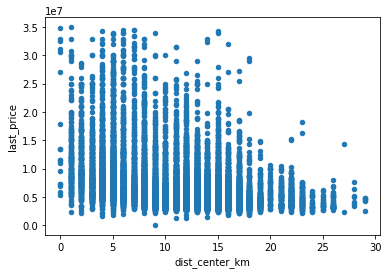

In [106]:
data_St_P.plot(x='dist_center_km', y='last_price', kind='scatter');
print('Коэффициент корреляции:', data_St_P['dist_center_km'].corr(data_St_P['last_price']))

По данной диаграмме рассеяния можно сделать вывод о зависимости цены от расстояния до центра: чем дальше от центра, тем ниже цена, то есть зависмость является обратно пропорциональной. Однако зависимость цены от площади квартиры выражена сильнее.

### Выводы

**Цель проекта:** найти интересные зависимости на рынке недвижимости.

Наш проект состоял из трех частей: 
1. предобработка данных
2. подсчет новых параметров
3. поиск зависимостей

В первой части проекта мы тщательно обработали данные: проанализировали пропуски в дынных, в некоторых данных пропуски заменили на средние/медианые значения (распределение не изменилось в таком случае), где-то вместо пропусков поставили флаги для того, чтобы не засорять данные, и в таких параметрах, как балкон и аппартаменты, мы заполнили пропуски нулями (так как не указанные значения могут свидетельствовать об отсутсвии параметров). Далее мы обработали выбросы: в некоторых признаках  мы предположили, что в аномальных значениях могли быть ошибки ввода, поэтому там где можно, отнормировали выбросы, при этом распеределение не изменилось.Так же в столбце цен нашли аномально высокие цены, в этом случае мы отбросили такие строки (99% квартиль), распределение не изменилось. В этом случае можно было снова отнормировать цены, однако аномальных бырасов было всего 22, поэтому для более достоверных данных мы их отбросили.

Во второй части проекта мы добавили такие параметры как: цена одного квадратного метра, день недели публикации объявления (0 — понедельник, 1 — вторник и так далее),  месяц публикации объявления, год публикации объявления, тип этажа квартиры (значения — «первый», «последний», «другой»), расстояние до центра города в километрах (переведите из м в км и округлите до целых значений). Это нам нужно для дальнейшего анализа зависимостей.

В третьей части проекта мы проанализировали зависимости признаков от цены. Было выяснено, что сама сильная зависимость присутсвует между ценой и общей площадью квратиры ($corr=0.8$). Следующая зависимость цена и жилая площадь ($corr=0.7$), затем зависимость цены и площади кухни ($corr=0.6$). Так же на цену влияет расположение от центра, парка, пруда и аэропорта, однако эта зависимость не является определяющей. Цена квартиры так же зависит от этажа, на котором она находится (квартира дешевле на первом и на последнем этаже). В проекте мы анализировали Санкт-Петербург и Ленинградскую область. Было выяснено, что самая высокая цена квадратного метра в Санкт-Петербурге. Так же если рассматривать публикаци только в Санкт-Петербурге, то цена квартиры уже сильнее зависит от расположения от центра города, чем в других населенных пунктах.